# Import package

In [1]:
import os
import math
import time 
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from collections import Counter

# Global variable

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device_lib.list_local_devices())
label_classes = ['森森', '牛排', '巧巧', '小白', '花捲', '金毛', '吊吊', '黑胖', '乖狗', '橘子']

num_of_class = len(label_classes)
batch_size = 64
target_size = (224, 224)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14847422203095114853
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6286213120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14008166987608974669
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


# Preprocess data

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    # shear_range=0.1,
    zoom_range=0.3,
    # fill_mode='nearest'
)

# train
train_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
for i, j in Counter(train_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
print()

# valid
valid_generator = train_datagen.flow_from_directory(
    directory="data/",
    target_size=target_size,
    color_mode="rgb",
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size,
    shuffle=True,
    subset='validation'
)
for i, j in Counter(valid_generator.classes).items():
    print(f"{label_classes[i]} with {j:3d} images")
    

Found 793 images belonging to 10 classes.
森森 with 121 images
牛排 with 112 images
巧巧 with  64 images
小白 with 320 images
花捲 with   6 images
金毛 with   4 images
吊吊 with   5 images
黑胖 with 113 images
乖狗 with  28 images
橘子 with  20 images

Found 194 images belonging to 10 classes.
森森 with  30 images
牛排 with  28 images
巧巧 with  16 images
小白 with  80 images
花捲 with   1 images
吊吊 with   1 images
黑胖 with  28 images
乖狗 with   6 images
橘子 with   4 images


金毛


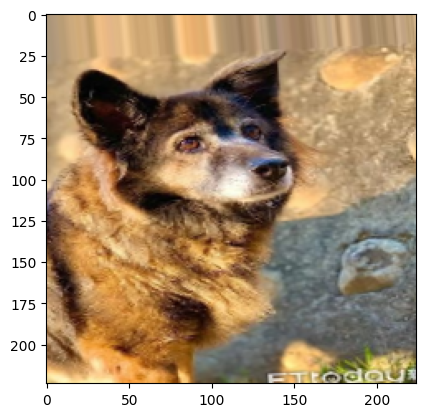

黑胖


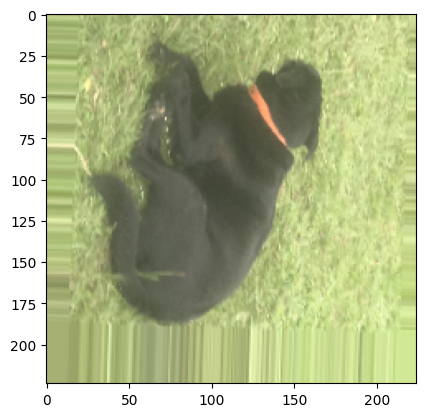

森森


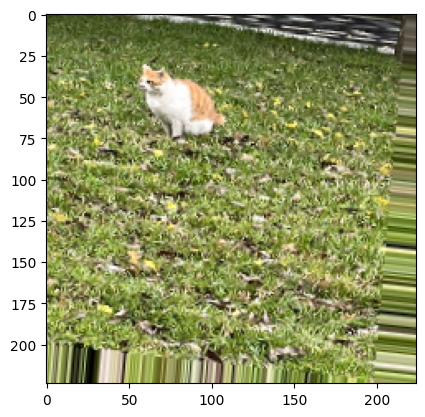

In [25]:
for my_batch in train_generator:
    images = my_batch[0]
    labels = my_batch[1]
    for i in range(3):
        print(label_classes[labels[i].argmax()])
        plt.imshow(images[i])
        plt.show()
    break

# Build model

In [41]:
base_model = tf.keras.applications.MobileNetV3Large(
    include_top = False,
    input_shape = target_size + (3, ),
    weights = 'imagenet'
)


base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.Conv2D(filters=128, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_of_class, activation='softmax')
])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 5, 128)         1474688   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
Total params: 5,702,410
Trainable params: 1,475,978
Non-trainable params: 4,226,432
_________________________________________________________________


# Start training

In [42]:
# Set model

my_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath='weights_save/weights{epoch:03d}_{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    save_weights_only=True,
    mode='max'
)]

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

12/12 [==============================] - 84s 7s/step - loss: 1.2762 - accuracy: 0.5501 - val_loss: 1.1508 - val_accuracy: 0.5677


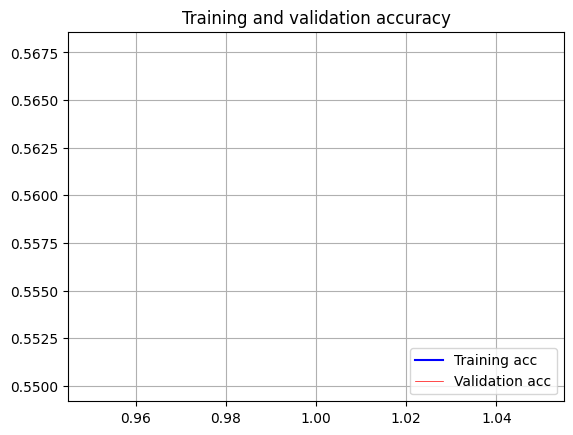

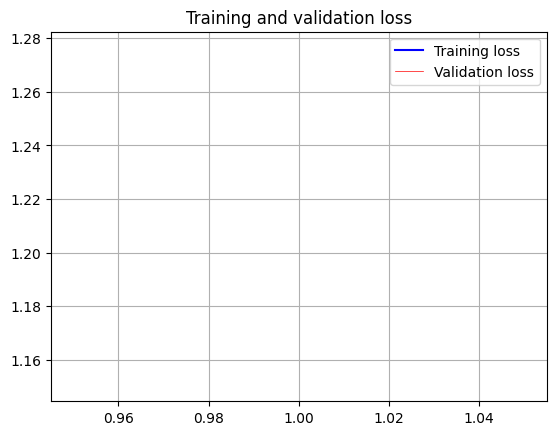

In [43]:
model.load_weights(filepath='weights_save/weights005_0.72.hdf5')

history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=1,
    callbacks=my_callback
)

acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc', linewidth=0.5)
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.grid()
# 儲存acc學習曲線
# plt.savefig('./acc.png')
plt.show()
# 畫出loss學習曲線
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss', linewidth=0.5)
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid()
# 儲存loss學習曲線
# plt.savefig('loss.png')
plt.show()

In [ ]:
pred_train = model.evaluate(train_generator, verbose=0, steps=STEP_SIZE_TRAIN)
pred_val = model.evaluate(valid_generator, verbose=0, steps=STEP_SIZE_VALID)

print("Train loss:", pred_train[0])
print("Train accuracy:", pred_train[1])
print("Validation loss:", pred_val[0])
print("Validation accuracy:", pred_val[1])

In [44]:
images = []
labels = []
predictions = []

for data, label in valid_generator:
    
    prediction = np.argmax(model.predict(data), axis=1)
    predictions.extend(prediction)
    
    images.extend(data)
    
    labels.extend(np.argmax(label, axis=1))
    
    if (len(predictions) == valid_generator.n):
        break

label=森森 | predict=森森


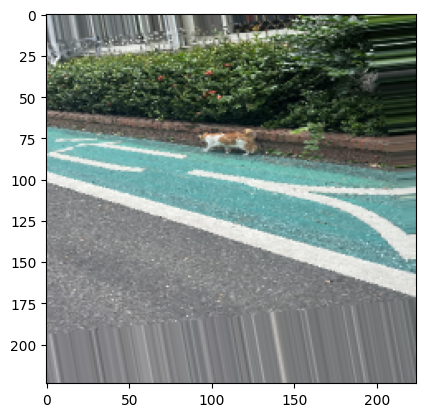

label=小白 | predict=森森


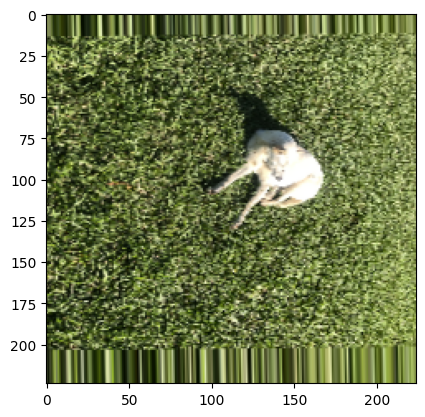

label=小白 | predict=小白


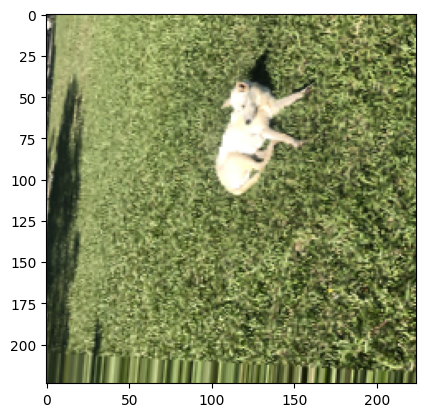

label=牛排 | predict=牛排


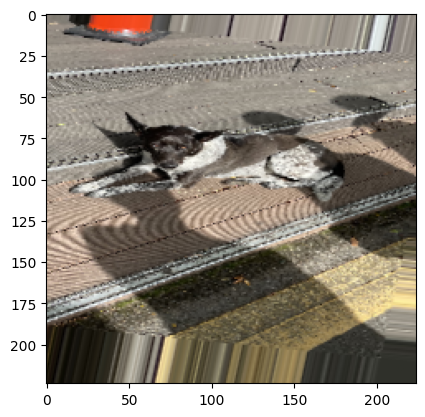

label=森森 | predict=森森


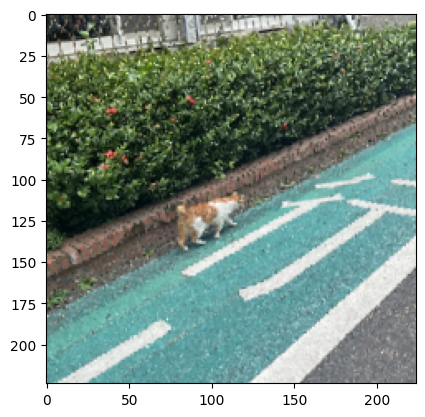

In [45]:
for i in range(4,9):
    print(f"label={label_classes[labels[i]]} | predict={label_classes[predictions[i]]}")
    # plt.subplot(2, 2, i+1)
    plt.imshow(images[i])
    plt.show()

# Convert to tflite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("model.tflite", "wb") as fh:
    fh.write(tflite_model)